# Predição de Ataques Cardíacos

O presente trabalho visa determinar, através de modelos de aprendizado supervisionado, se uma pessoa tem mais ou menos chance de sofrer um atarque cardíaco.

## Definição de Estado Inicial

As linhas abaixo importam as bibliotecas `random` e `numpy` e definem os valores dos estados das funções que dependem de aleatoriedade.

Esta definição foi feita para que se obtenha os mesmos resultados durante os testes e deve ser removida para uso correto dos algoritmos.

In [1]:
import numpy as np
np.random.seed(1234)

import random
random.seed(1234)

## Bibliotecas auxiliares

## Os Dados

In [2]:
import pandas as pd

dataset = pd.read_csv('data/heart.csv');

dataset.drop(['oldpeak'], axis=1, inplace=True)
dataset.drop(['slp'], axis=1, inplace=True)
dataset.drop(['thall'], axis=1, inplace=True)

dataset.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,caa,output
0,63,1,3,145,233,1,0,150,0,0,1
1,37,1,2,130,250,0,1,187,0,0,1
2,41,0,1,130,204,0,0,172,0,0,1
3,56,1,1,120,236,0,1,178,0,0,1
4,57,0,0,120,354,0,1,163,1,0,1


In [3]:
number_of_instances = len(dataset)

number_positive_intances = len(dataset[dataset['output'] == 1])
number_negative_intances = len(dataset[dataset['output'] == 0])

number_attributes = len(dataset.columns) - 1

print(f'Número de instâncias: {number_of_instances}')
print(f'Número de instâncias positivas: {number_positive_intances}')
print(f'Número de instâncias negativas: {number_negative_intances}')
print(f'Número de atributos: {number_attributes}')

Número de instâncias: 303
Número de instâncias positivas: 165
Número de instâncias negativas: 138
Número de atributos: 10


## Normalização

In [4]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

normalized_dataset = dataset.copy()

normalized_dataset['age'] = min_max_scaler.fit_transform(dataset['age'].values.reshape(-1, 1))
normalized_dataset['trtbps'] = min_max_scaler.fit_transform(dataset['trtbps'].values.reshape(-1, 1))
normalized_dataset['chol'] = min_max_scaler.fit_transform(dataset['chol'].values.reshape(-1, 1))
normalized_dataset['thalachh'] = min_max_scaler.fit_transform(dataset['thalachh'].values.reshape(-1, 1))
normalized_dataset['caa'] = min_max_scaler.fit_transform(dataset['caa'].values.reshape(-1, 1))

## Cross Validation

In [5]:
import random

def k_fold_dataset(dataset, folds):
    # obtém o tamanho do dataset
    dataset_size = len(dataset)
    
    # obtém o tamanho de cada fold
    fold_size = int(dataset_size / folds)
    
    # obtém os índices dos elementos do dataset
    indexes = list(dataset.index)
    
    # embaralha os elementos do dataset
    indexes_shuffled = indexes[:]
    random.shuffle(indexes_shuffled)
    
    # cria os folds
    folds_indexes = [indexes_shuffled[i:i + fold_size] for i in range(0, dataset_size, fold_size)]

    return folds_indexes

def k_fold_cross_validation(dataset, folds):
    # obtém os folds para cada classe separadamente
    folds_positive = k_fold_dataset(dataset[dataset['output'] == 1], folds)
    folds_negative = k_fold_dataset(dataset[dataset['output'] == 0], folds)

    # junta os folds das duas classes
    folds_indexes = []
    for i in range(folds):
        folds_indexes.append([*folds_positive[i], *folds_negative[i]])

    return folds_indexes


## Cálculo da Matriz de Confusão

In [6]:
def compute_confusion_matrix(predicted, expected):
    real_positives = 0
    real_negatives = 0
    false_positives = 0
    false_negatives = 0

    for i in range(len(predicted)):
        if predicted[i] == 1 and expected[i] == 1:
            real_positives += 1
        elif predicted[i] == 0 and expected[i] == 0:
            real_negatives += 1
        elif predicted[i] == 1 and expected[i] == 0:
            false_positives += 1
        elif predicted[i] == 0 and expected[i] == 1:
            false_negatives += 1

    return real_positives, real_negatives, false_positives, false_negatives

## Função de Avaliação

In [7]:
import numpy as np

def compute_metrics(predicted, expected):
    # computa a matriz de confusão
    real_positives, real_negatives, false_positives, false_negatives = compute_confusion_matrix(predicted, expected)

    # computa a acurácia, precisão e recall
    accuracy = (real_positives + real_negatives) / (real_positives + real_negatives + false_positives + false_negatives)
    precision = real_positives / (real_positives + false_positives)
    recall = real_positives / (real_positives + false_negatives)

    # computa a f1
    f1 = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1

def evaluate_classifier(dataset, classifier, folds = 5):
    # obtém os folds
    folds_indexes = k_fold_cross_validation(dataset, folds)

    # inicializa a matriz de métricas
    metrics = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1'])

    # para cada fold
    for i in range(len(folds_indexes)):
        # obtém os índices dos elementos do fold
        fold = folds_indexes[i]

        # obtém os elementos do fold     
        fold_dataset = dataset.loc[fold, :]

        # obtém os elementos não do fold
        non_fold_dataset = dataset.drop(fold_dataset.index)

        # obtém os elementos do fold para treino e os elementos não do fold para teste
        train_dataset = non_fold_dataset
        test_dataset = fold_dataset

        # treina o classificador com os folds de treinamento
        classifier.fit(train_dataset.drop(['output'], axis=1), train_dataset['output'])

        # obtém os resultados do classificador para o fold de teste
        predicted = classifier.predict(test_dataset.drop(['output'], axis=1))

        # arredonda os resultados para 0 ou 1
        predicted = [round(value) for value in predicted]

        # adiciona os resultados ao dataframe
        metrics.loc[i] = compute_metrics(predicted, test_dataset['output'].values)

    return metrics

## Função para Apresentação dos Resultados

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_data(data, title, data_index):
    plt.subplot(2, 4, data_index * 2 + 1)
    sns.lineplot(x=range(len(data)), y=data)
    plt.xlabel('Fold')
    plt.xticks(range(len(data)), range(1, len(data) + 1))
    plt.ylabel(title)
    plt.ylim(-0.1, 1.1)
    plt.title(f'{title} - Mean: {data.mean():.2f} - Std: {data.std():.2f}')

    plt.subplot(2, 4, data_index * 2 + 2)
    sns.boxplot(x=data)
    plt.xlabel(title)
    plt.xlim(-0.1, 1.1)
    plt.title(f'{title} - Mean: {data.mean():.2f} - Std: {data.std():.2f}')

def plot_results(metrics, title):
    # obtém os resultados
    accuracy = metrics['accuracy']
    precision = metrics['precision']
    recall = metrics['recall']
    f1 = metrics['f1']

    # plota os gráficos
    fig = plt.figure(figsize=(20, 10))

    sns.set_theme()

    plot_data(accuracy, 'Accuracy', 0);
    plot_data(precision, 'Precision', 1);
    plot_data(recall, 'Recall', 2);
    plot_data(f1, 'F1', 3);
    
    plt.suptitle(title)

    fig.tight_layout()
                    
    plt.show()

## Árvore de Decisão

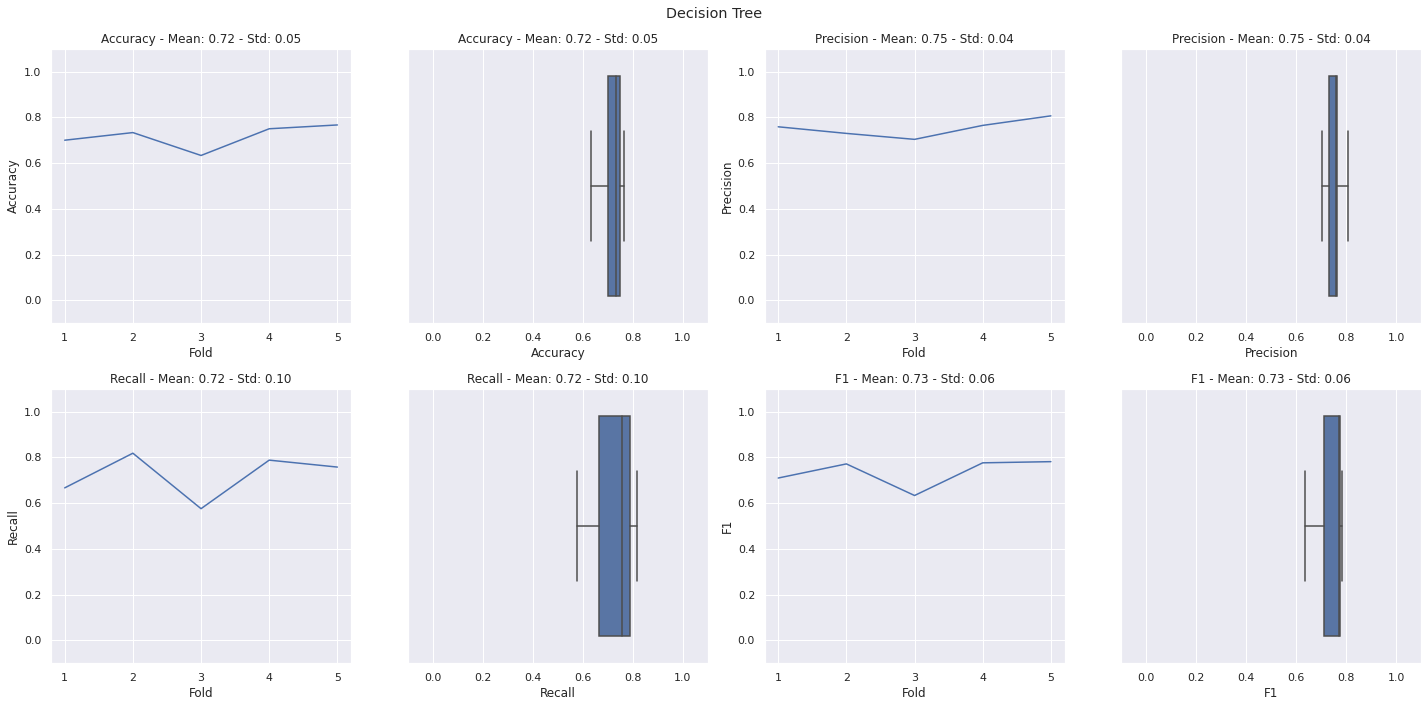

In [9]:
from sklearn import tree

classifier = tree.DecisionTreeClassifier()

metrics_tree = evaluate_classifier(normalized_dataset, classifier)

plot_results(metrics_tree, 'Decision Tree')

## Regressão Linear

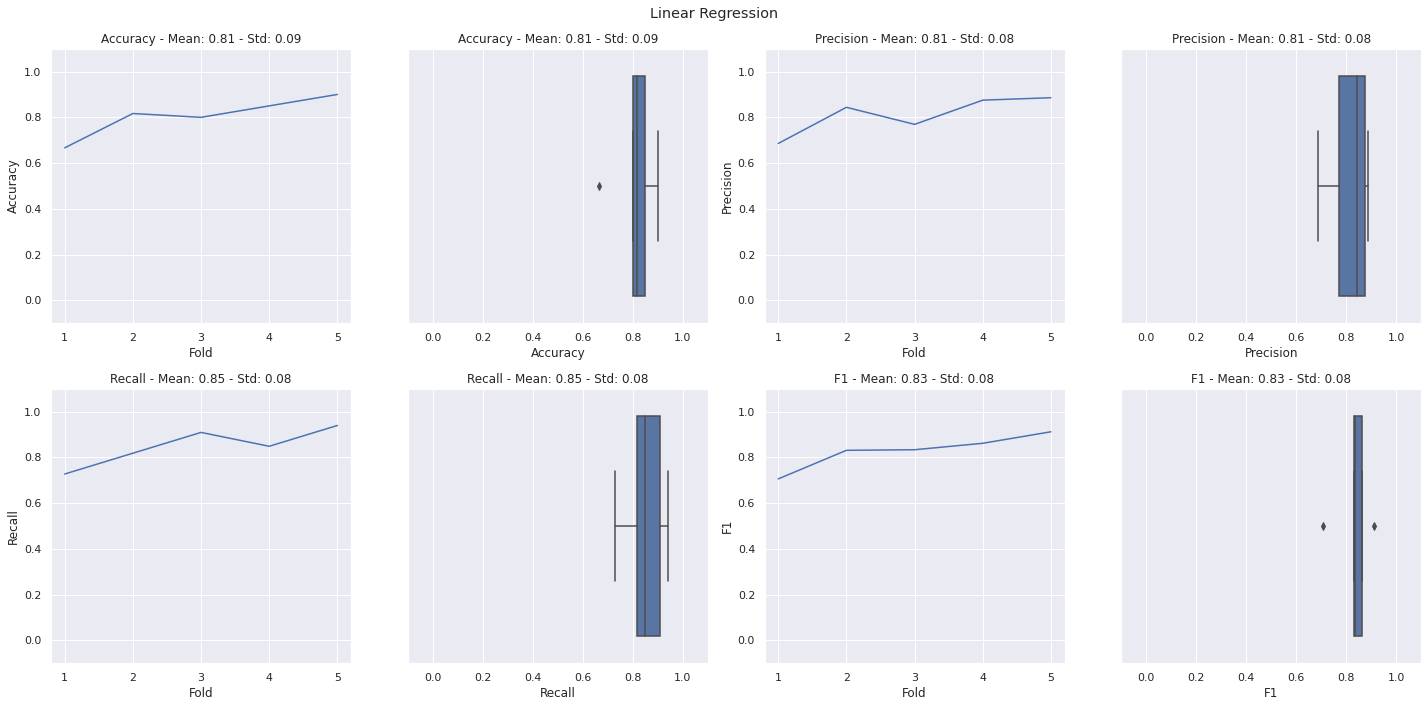

In [10]:
from sklearn import linear_model

classifier = linear_model.LinearRegression()

metrics_linear_regression = evaluate_classifier(normalized_dataset, classifier)

plot_results(metrics_linear_regression, 'Linear Regression')

## Random Forest

O algoritmo _Random Forest_ possui o hiperparâmetro de quantidade de estimadores, logo é necessário encontrar a melhor configuração de hiperparâmetros antes de determinar o melhor modelo.

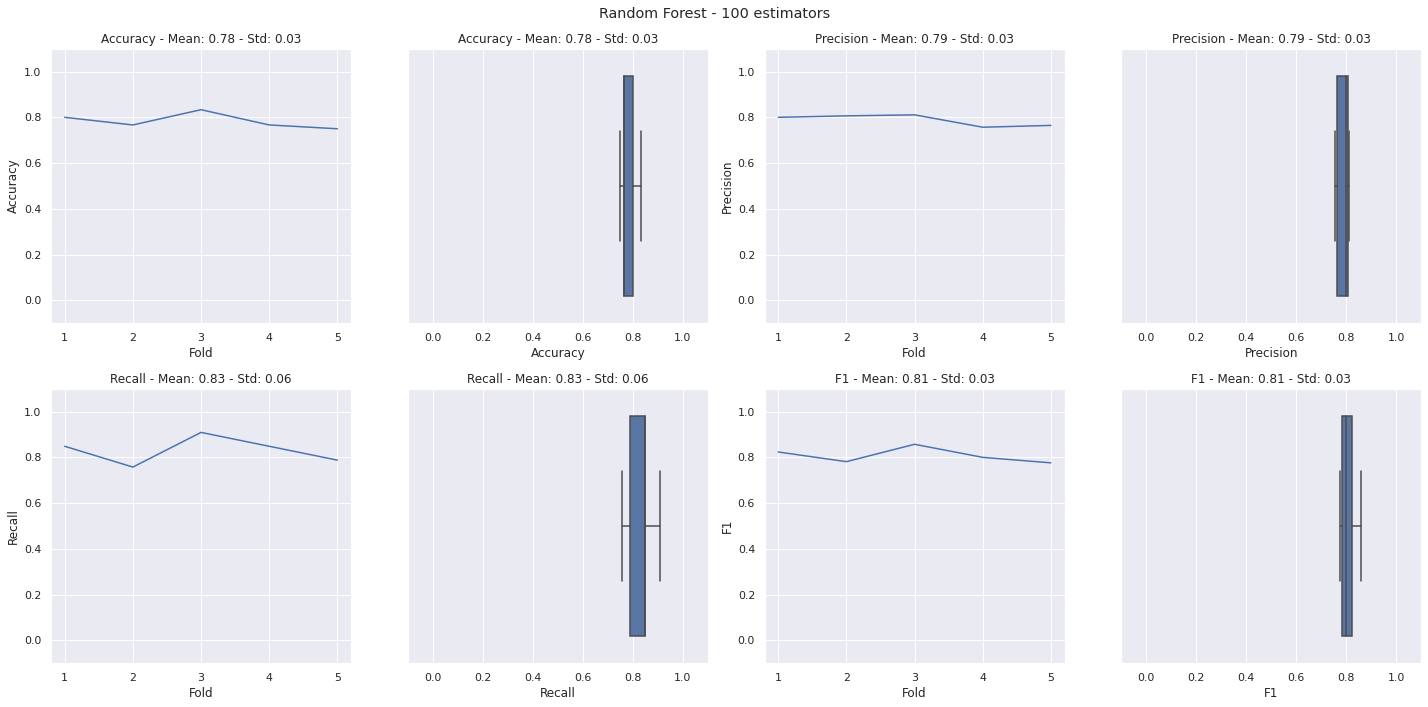

In [11]:
from sklearn import ensemble

# define os possíveis valores para o hiperparâmetro
estimators = [5, 10, 25, 50, 100, 200]

# obtém os folds externos
folds = k_fold_cross_validation(normalized_dataset, 10)

# inicializa o dataframe com os resultados
metrics = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1', 'estimators'])

# para cada fold
for fold_number in range(len(folds)):
    fold = folds[fold_number]

    # obtém os elementos do fold
    fold_data = normalized_dataset.iloc[fold, :]

    # obtém os elementos não do fold
    non_fold_data = normalized_dataset.drop(fold_data.index)

    # para cada possível valor para o hiperparâmetro
    for i in range(len(estimators)):
        # cria um classificador
        classifier = ensemble.RandomForestClassifier(n_estimators=estimators[i])

        # avalia o classificador com os folds de treinamento externos
        test_metrics = evaluate_classifier(non_fold_data, classifier)

        # adiciona os resultados ao dataframe
        metrics.loc[fold_number * len(estimators) + i] = [*test_metrics.mean(), estimators[i]]

# obtém o valor para o hiperparâmetro que obteve o melhor resultado médio
best_number_of_estimators = int(metrics.groupby('estimators').mean()['f1'].idxmax())

# treina um classificador com o melhor valor para o hiperparâmetro e o avalia
classifier = ensemble.RandomForestClassifier(n_estimators=best_number_of_estimators)

metrics_random_forest = evaluate_classifier(normalized_dataset, classifier)

plot_results(metrics_random_forest, f'Random Forest - {best_number_of_estimators} estimators')

## Melhor modelo

In [12]:
tree_mean = metrics_tree.mean()
linear_regression_mean = metrics_linear_regression.mean()
random_forest_mean = metrics_random_forest.mean()

means = pd.DataFrame([tree_mean, linear_regression_mean, random_forest_mean], index=['Tree', 'Linear Regression', 'Random Forest'])

best_accuracy = means['accuracy'].idxmax()
best_precision = means['precision'].idxmax()
best_recall = means['recall'].idxmax()
best_f1 = means['f1'].idxmax()

print(f'Best accuracy: {means.loc[best_accuracy, "accuracy"]:.2f} - {best_accuracy}')
print(f'Best precision: {means.loc[best_precision, "precision"]:.2f} - {best_precision}')
print(f'Best recall: {means.loc[best_recall, "recall"]:.2f} - {best_recall}')
print(f'Best f1: {means.loc[best_f1, "f1"]:.2f} - {best_f1}')

Best accuracy: 0.81 - Linear Regression
Best precision: 0.81 - Linear Regression
Best recall: 0.85 - Linear Regression
Best f1: 0.83 - Linear Regression
